In [1]:
from agrovoc import *
from agrovoc_utils import *
from rdflib import Graph
lang = 'en'
g = Graph()
a = Agrovoc(g, lang=lang)

Now loading the dictionary...


  0%|          | 14/36938 [00:00<30:40, 20.06it/s]

Now indexing the dictionary...


100%|██████████| 36938/36938 [04:38<00:00, 132.58it/s]


In [7]:
import json
import functools
import pandas as pd

file = pd.read_excel('https://github.com/Kipre/etude-technique/blob/master/2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx?raw=true')
file = file.loc[file.LANGUE_DOC=="eng"]

def to_agrovoc(concepts):
    result = set()
    for concept in concepts:
        result = result.union(a.find_with_agrovoc(concept))
    return result

def intersection(set1, set2):
    inter_concept = set()
    for concept1 in set1 : 
        for concept2 in set2 : 
            if concept1[0] == concept2[0]:
                inter_concept.add(concept1)
                break
    return inter_concept           

class Callback:
    def __init__(self, message=""):
        self.average_accuracy=0
        self.average_precsision=0
        self.average_recovery=0
        self.average_nb_entities=0
        self.message = message
        self.examples = 0
        self.memory = []
        self.text=""
    def update(self, set1, List):
        set2 = to_agrovoc(List)
        self.text += ' '.join([word.replace(' ', '_') for _, word in set2])
        recovery = len(set2)/len(List)if len(List)>0 else 0
        res = intersection(set1, set2)
        accuracy = len(res)/len(set1)if len(set1)>0 else 0
        precsision = len(res)/len(set2)if len(set2)>0 else 0
        self.memory.append([accuracy, precsision, recovery])
        self.average_accuracy = (self.average_accuracy * self.examples + accuracy)/(self.examples + 1)
        self.average_nb_entities = (self.average_nb_entities * self.examples + len(List))/(self.examples + 1)
        self.average_precsision = (self.average_precsision * self.examples + precsision)/(self.examples + 1)
        self.average_recovery = (self.average_recovery * self.examples + recovery)/(self.examples + 1)
        self.examples += 1
        return("{} : {} , {} , {}".format(self.message, accuracy, precsision, recovery))
        


cagro = Callback("Agrovoc")
for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), row["DESCRIPTEURS"].split(";")))
    else:
        descriptors = []
        continue
    #agris = list(map(lambda x: x.strip().split(" et "), row["AGRIS"].split(";")))
    #agris = list(functools.reduce(lambda x, y: x + y, agris))
    metadata = to_agrovoc(descriptors)
    
    xml = pdf_to_xml(pdf)
    try:
        text_json = extract_entities(xml, lang=lang)
    except:
        print('Failed to process xml', xml[:100])
        continue
    try:
        text = json.loads(text_json)
    except:
        print(text_json)
        continue
    entities = [part["rawName"].strip() for part in text["entities"]]
    categories = [part["category"].strip() for part in text["global_categories"]]
    ent_and_cat = entities + categories
    #ner_metadata = to_agrovoc(entities).union(to_agrovoc(categories))
    
    print(cagro.update(metadata, ent_and_cat))
  
    if i > 1000:
        break
print(cagro.average_accuracy)



Agrovoc : 0.36363636363636365 , 0.11428571428571428 , 0.08215962441314555
Agrovoc : 0.6 , 0.03488372093023256 , 0.15114235500878734
{"runtime": 35243, "nbest": false, "text": "  Using the selected set of dimension  Conservation Agriculture systems and technologies will be described in a qualitative  through descriptive stories  and quantitative ways  through results obtained on field  The stories will highlight aspects of the dimensions  environmental sustainability  quality of life  regulatory environment and service provision  commercialization and advocacy  that are relevant and typical to the particular practice  The selected dimensions are the following  Lie and Tivet  2008    Quality of Life  This dimension is about the sensitivity that a practice has for the improvement of the quality of the life of the farmer and his or her livelihood  The Quality of Life dimension adopts the Sustainable Livelihoods Approach  SLA  as developed by DFID   3  The quality of life equals a sustainab

Agrovoc : 0.5555555555555556 , 0.023923444976076555 , 0.22139830508474576
Agrovoc : 1.0 , 0.011764705882352941 , 0.07293007293007293
Agrovoc : 1.0 , 0.125 , 0.8421052631578947
Agrovoc : 1.0 , 0.01098901098901099 , 0.14748784440842788
Agrovoc : 1.0 , 0.03225806451612903 , 0.082010582010582
Agrovoc : 0.75 , 0.02459016393442623 , 0.0899042004421518
Failed to process xml [NO_BLOCKS] PDF parsing resulted in empty content
Agrovoc : 0.2 , 0.03125 , 0.24806201550387597
Agrovoc : 0.5714285714285714 , 0.06349206349206349 , 0.07875
Agrovoc : 0.75 , 0.02459016393442623 , 0.27415730337078653
Failed to process xml [NO_BLOCKS] PDF parsing resulted in empty content
Agrovoc : 0.5 , 0.07142857142857142 , 0.06349206349206349
Agrovoc : 0.0 , 0.0 , 0.04228486646884273
Agrovoc : 0.5714285714285714 , 0.06557377049180328 , 0.20962199312714777
Agrovoc : 0.42857142857142855 , 0.08695652173913043 , 0.11979166666666667
Agrovoc : 0.25 , 0.045454545454545456 , 0.5789473684210527
Agrovoc : 0.35 , 0.1794871794871795 

KeyboardInterrupt: 

In [8]:
print(cagro.average_accuracy, cagro.average_precsision, cagro.average_recovery, cagro.average_nb_entities)

0.49087299398564377 0.06193799964135811 0.1508707444973125 840.4199999999998


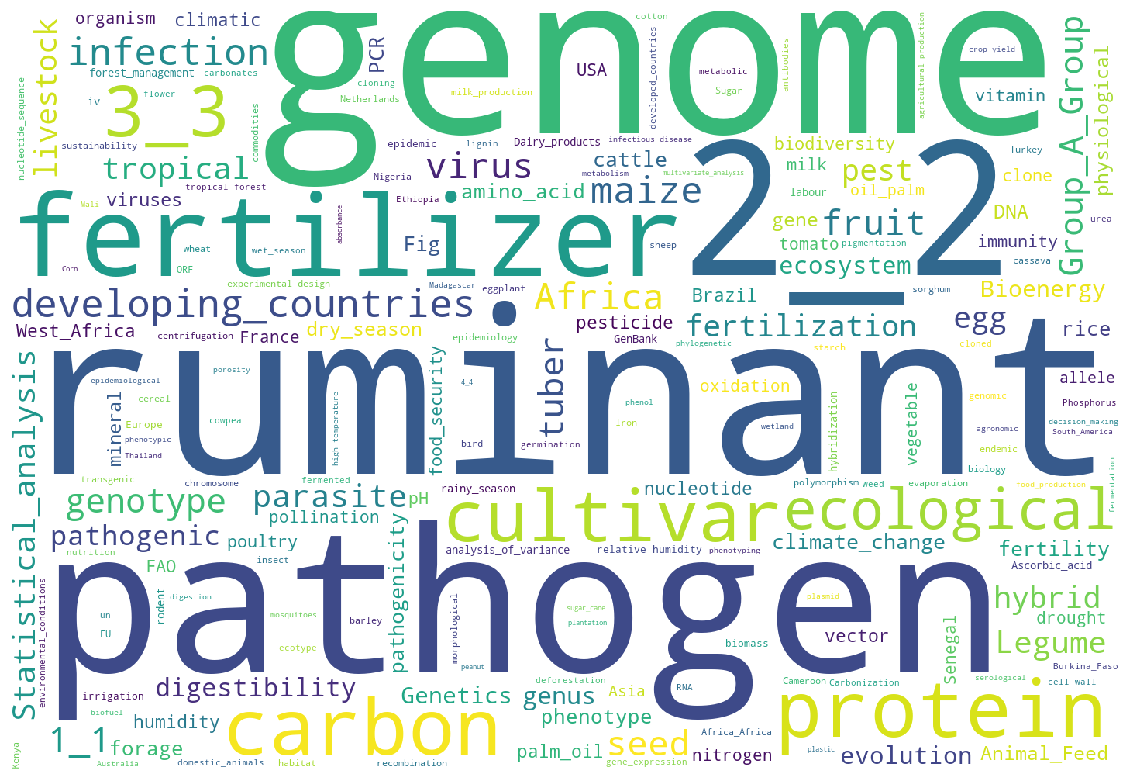

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
img = WordCloud(width=1440, height=990, margin= 10, background_color='white').generate(cagro.text)
ax.imshow(img)
plt.axis('off')
plt.savefig('resources/wordclouden.png')